# Peregrine Deployment Strategist Take-Home

### 

## Overview

This Jupyter notebook contains Will Tholke's submission for Peregrine's Deployment Strategist take-home assignment, submitted the morning of November 17th, 2025. Before getting started, make sure to follow the Setup guide in the [README.md](README.md).

## Part 1: Data Exploration & Hypothesis Development

### 1.1: Data Loading & Cleaning

**Objective**: Load, prepare, and describe the dataset ahead of exploratory analysis.

In [543]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [544]:
df= pd.read_csv('dataset.csv')
print("Successfully loaded dataset of money transfers made by The Flower Shop.")

df.head()

Successfully loaded dataset of money transfers made by The Flower Shop.


,id,Send DateTime,Pay DateTime,Amount,Sender Name_,Sender Address_,Sender ID1 info,Sender City,Sender State,Payee Name_,...,Send Agent State,Send Country,Send Operator Name_,Pay Agent Name_,Pay Agent City,Pay Agent State,Pay Country,Pay Operator Name_,Sender Age,Payee Age
0,0,12/26/2015 13:01,12/28/2015 9:19,990.0,name_1,address_1,1,PALO ALTO,CA,name_742,...,CA,UNITED STATES,operator_name_3,agent_1,MORELIA,NaN,MEXICO,operator_name_0,40.0,NaN
1,1,12/28/2015 15:36,12/28/2015 19:15,690.0,name_2,address_2,0,SAN JOSE,CA,name_3020,...,CA,UNITED STATES,operator_name_12,agent_2,MANZANILLO,NaN,MEXICO,operator_name_0,50.0,NaN
2,2,11/30/2015 20:55,12/1/2015 18:39,990.0,name_3,address_3,1,REDWOOD CITY,CA,name_3021,...,CA,UNITED STATES,operator_name_3,agent_3,YANGA,NaN,MEXICO,operator_name_0,47.0,NaN
3,3,12/8/2015 15:33,12/8/2015 17:37,1000.0,name_4,address_4,1,SAN CARLOS,CA,name_2609,...,CA,UNITED STATES,operator_name_12,agent_4,GUADALAJARA,NaN,MEXICO,operator_name_0,51.0,53.0
4,4,12/10/2015 14:48,12/10/2015 15:48,830.0,name_5,address_5,0,EAST PALO ALTO,CA,name_3022,...,CA,UNITED STATES,operator_name_12,agent_5,SAN SALVADOR,NaN,EL SALVADOR,operator_name_0,49.0,NaN


In [545]:
# Create deep copy & clean column names
df_copy = df.copy(deep=True)
df_copy.columns = df_copy.columns.str.strip().str.rstrip('_')

# Convert columns with person or location info to string dtype
string_columns = [
    'Sender Name', 'Sender Address', 'Sender City', 'Sender State',
    'Payee Name', 'Payee Address', 'Payee City', 'Payee State',
    'Send Agent Name', 'Send Agent City', 'Send Agent State',
    'Send Country', 'Send Operator Name',
    'Pay Agent Name', 'Pay Agent City', 'Pay Agent State',
    'Pay Country', 'Pay Operator Name'
]
for col in string_columns:
    if col in df_copy.columns:
        df_copy[col] = df_copy[col].astype('string')

# Convert datetime columns
df_copy['Send DateTime'] = pd.to_datetime(df_copy['Send DateTime'], format='%m/%d/%Y %H:%M', errors='coerce')
df_copy['Pay DateTime'] = pd.to_datetime(df_copy['Pay DateTime'], format='%m/%d/%Y %H:%M', errors='coerce')

# Ensure transaction amount and age values are numeric
df_copy['Amount'] = pd.to_numeric(df_copy['Amount'], errors='coerce')
df_copy['Sender Age'] = pd.to_numeric(df_copy['Sender Age'], errors='coerce')
df_copy['Payee Age'] = pd.to_numeric(df_copy['Payee Age'], errors='coerce')

# Convert ID info columns to bool
df_copy['Sender ID1 info'] = df_copy['Sender ID1 info'].astype(bool)
df_copy['Payee ID1 info'] = df_copy['Payee ID1 info'].astype(bool)

# Extract date components for temporal analysis
df_copy['Time Between Send Pay (hours)'] = (df_copy['Pay DateTime'] - df_copy['Send DateTime']).dt.total_seconds() / 3600
df_copy['Send Day of Week'] = df_copy['Send DateTime'].dt.day_name().astype('string')
df_copy['Send Hour'] = df_copy['Send DateTime'].dt.hour
df_copy['Pay Day of Week'] = df_copy['Pay DateTime'].dt.day_name().astype('string')
df_copy['Pay Hour'] = df_copy['Pay DateTime'].dt.hour

# Print initial report
print(f"Date range: {df_copy['Send DateTime'].min()} to {df_copy['Send DateTime'].max()}")
print(f"Total transactions: {len(df_copy)}")

print(f"\nMissing Pay DateTime: {df_copy['Pay DateTime'].isna().sum()}")
print(f"Missing Send DateTime: {df_copy['Send DateTime'].isna().sum()}")
print(f"\nMissing Amount: {df_copy['Amount'].isna().sum()}")
print(f"Negative Amount: {(df_copy['Amount'] < 0).sum()}")
print(f"Zero Amount: {(df_copy['Amount'] == 0).sum()}")
print(f"\nPay occurred before send: {(df_copy['Time Between Send Pay (hours)'] < 0).sum()}")

Date range: 2015-11-28 14:00:00 to 2020-11-25 19:38:00
Total transactions: 11399

Missing Pay DateTime: 11
Missing Send DateTime: 0

Missing Amount: 0
Negative Amount: 0
Zero Amount: 0

Pay occurred before send: 0


Looking at the initial data quality report above, the date range spans approximately 5 years–between 2015 and 2020–instead of being within the last year, which means that the California Office of the Attorney General has given us the wrong dataset. We should reach out to the to agency to inform them of their error and obtain up-to-date data on The Flower Shop. This extra transacton data from 2015 to 2020, although not recent, should be helpful in building a historical understanding of money movement through The Flower Shop.

We'll remove the transactions missing Pay DateTime since they will be unsusable in our analysis. However, we'll keep transactions that are missing city, state, age data, etc. since the missing data itself can qualify as suspicious behavior.

In [546]:
rows_before = len(df_copy)
df_copy = df_copy.dropna(subset=['Pay DateTime'])
rows_after = len(df_copy)
print(f"\nDropped {rows_before - rows_after} transactions with missing Pay DateTime.")


Dropped 11 transactions with missing Pay DateTime.


### 1.2: Exploratory Data Analysis

**Objective:** Explore the dataset and identify patterns in transactions.

In [547]:
# Create missing data flags
df_copy['missing_payee_state'] = df_copy['Payee State'].isna()
df_copy['missing_payee_city'] = df_copy['Payee City'].isna()
df_copy['missing_pay_agent_state'] = df_copy['Pay Agent State'].isna()
df_copy['missing_sender_state'] = df_copy['Sender State'].isna()
df_copy['missing_sender_city'] = df_copy['Sender City'].isna()
df_copy['missing_send_agent_state'] = df_copy['Send Agent State'].isna()
df_copy['missing_sender_age'] = df_copy['Sender Age'].isna()
df_copy['missing_payee_age'] = df_copy['Payee Age'].isna()

# Create suspicious behavior flags
df_copy['no_sender_id'] = ~df_copy['Sender ID1 info']
df_copy['no_payee_id'] = ~df_copy['Payee ID1 info']
df_copy['no_ids_provided'] = df_copy['no_sender_id'] & df_copy['no_payee_id']
df_copy['quick_turnaround'] = df_copy['Time Between Send Pay (hours)'] < 1
df_copy['round_amount'] = df_copy['Amount'] % 100 == 0

# Create missing field combo flags
df_copy['missing_payee_location'] = df_copy['missing_payee_state'] & df_copy['missing_payee_city']
df_copy['missing_sender_location'] = df_copy['missing_sender_state'] & df_copy['missing_sender_city']
df_copy['no_ids_and_missing_sender_location'] = df_copy['no_ids_provided'] & df_copy['missing_sender_location']
df_copy['no_ids_and_missing_payee_location'] = df_copy['no_ids_provided'] & df_copy['missing_payee_location']

# Count missing fields per transaction
missing_cols = [
    'Payee State', 'Payee City', 'Pay Agent State',
    'Sender State', 'Sender City', 'Send Agent State',
    'Sender Age', 'Payee Age'
]
df_copy['missing_data_ct'] = df_copy[missing_cols].isna().sum(axis=1)

df.head()

# Print suspicious indicators and missing data report
print(f"\nSuspicious Indicators:")
print(f"  - Missing any ID (sender or payee): {df_copy['no_sender_id'].sum() + df_copy['no_payee_id'].sum()}")
print(f"  - Both IDs missing: {df_copy['no_ids_provided'].sum()}")
print(f"  - Quick turnaround (<1 hr): {df_copy['quick_turnaround'].sum()}")
print(f"  - Round amounts (common in structuring): {df_copy['round_amount'].sum()}")
print(f"  - High missing data count (>3): {(df_copy['missing_data_ct'] > 3).sum()}")

print(f"\nSuspicious Missing-Data Combos:")
print(f"  - Missing payee location (state & city): {df_copy['missing_payee_location'].sum()}")
print(f"  - Missing sender location (state & city): {df_copy['missing_sender_location'].sum()}")
print(f"  - Both IDs missing + sender location missing: {df_copy['no_ids_and_missing_sender_location'].sum()}")
print(f"  - Both IDs missing + payee location missing: {df_copy['no_ids_and_missing_payee_location'].sum()}")


Suspicious Indicators:
  - Missing any ID (sender or payee): 5926
  - Both IDs missing: 1195
  - Quick turnaround (<1 hr): 1336
  - Round amounts (common in structuring): 7996
  - High missing data count (>3): 655

Suspicious Missing-Data Combos:
  - Missing payee location (state & city): 627
  - Missing sender location (state & city): 5
  - Both IDs missing + sender location missing: 2
  - Both IDs missing + payee location missing: 247


#### Transaction Size (Amount) Patterns

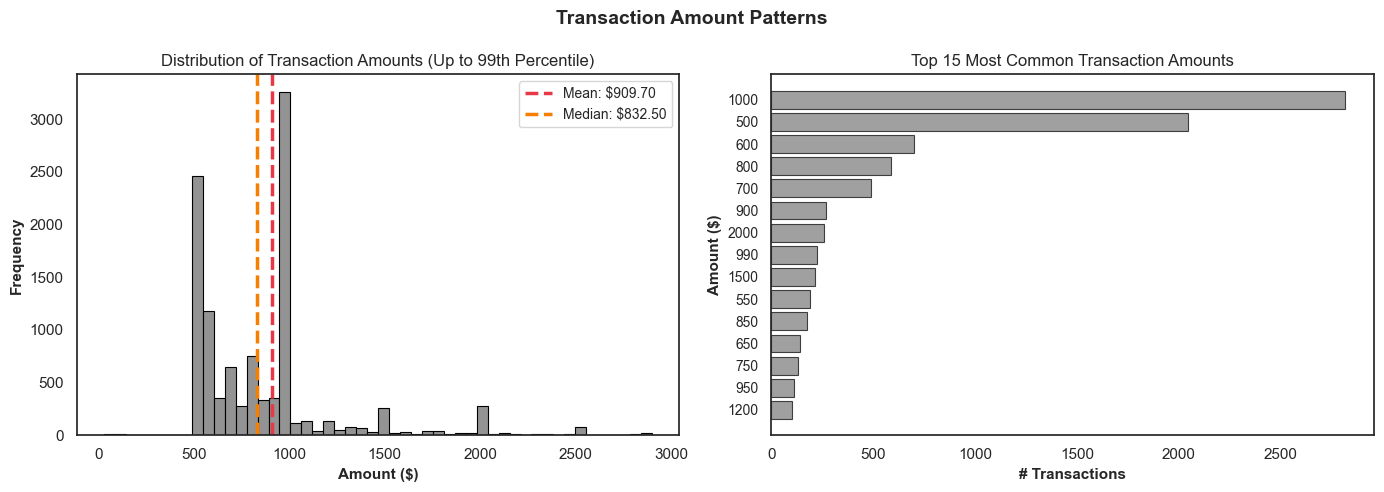


Transaction Amount Statistics:
count    11388.000000
mean       909.704953
std        515.286894
min         30.000000
25%        588.875000
50%        832.500000
75%       1000.000000
max       9000.000000
Name: Amount, dtype: float64

Observations:
  - Transaction amounts show a concentrated distribution around $1000.00
  - The mean is higher than the median, since some larger transactions skew the distribution


In [548]:
sns.set_theme(style="white", palette="husl")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Transaction Amount Patterns', fontsize=14, fontweight='bold')

# Plot 1: Distribution of transaction amounts
mean_amt = df_copy['Amount'].mean()
median_amt = df_copy['Amount'].median()
p99 = df_copy['Amount'].quantile(0.99)
main_distribution = df_copy[df_copy['Amount'] <= p99]

sns.histplot(main_distribution['Amount'], bins=50, edgecolor='black', alpha=0.8, color='#787878', ax=axes[0], linewidth=0.8)
axes[0].axvline(mean_amt, color='#E63946', linestyle='--', linewidth=2.5, label=f'Mean: ${mean_amt:.2f}')
axes[0].axvline(median_amt, color='#F77F00', linestyle='--', linewidth=2.5, label=f'Median: ${median_amt:.2f}')
axes[0].set_xlabel('Amount ($)', fontweight='bold', fontsize=11)
axes[0].set_ylabel('Frequency', fontweight='bold', fontsize=11)
axes[0].set_title(f'Distribution of Transaction Amounts (Up to 99th Percentile)', fontsize=12)
axes[0].legend(fontsize=10)

# Plot 2: Top 15 most common transaction amounts
top_amounts = df_copy['Amount'].value_counts().head(15)

axes[1].barh(range(len(top_amounts)), top_amounts.values, color='#787878', edgecolor='black', linewidth=0.8, alpha=0.7)
axes[1].set_yticks(range(len(top_amounts)))
axes[1].set_yticklabels([f'{x:.0f}' for x in top_amounts.index], fontsize=10)
axes[1].set_ylabel('Amount ($)', fontweight='bold', fontsize=11)
axes[1].set_xlabel('# Transactions', fontweight='bold', fontsize=11)
axes[1].set_title('Top 15 Most Common Transaction Amounts', fontsize=12)
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

# Quick summary
print(f"\nTransaction Amount Statistics:")
print(df_copy['Amount'].describe())

print("\nObservations:")
print(f"  - Transaction amounts show a concentrated distribution around ${df_copy['Amount'].mode().values[0]:.2f}")
print("  - The mean is higher than the median, since some larger transactions skew the distribution")

#### Transaction Frequency Patterns

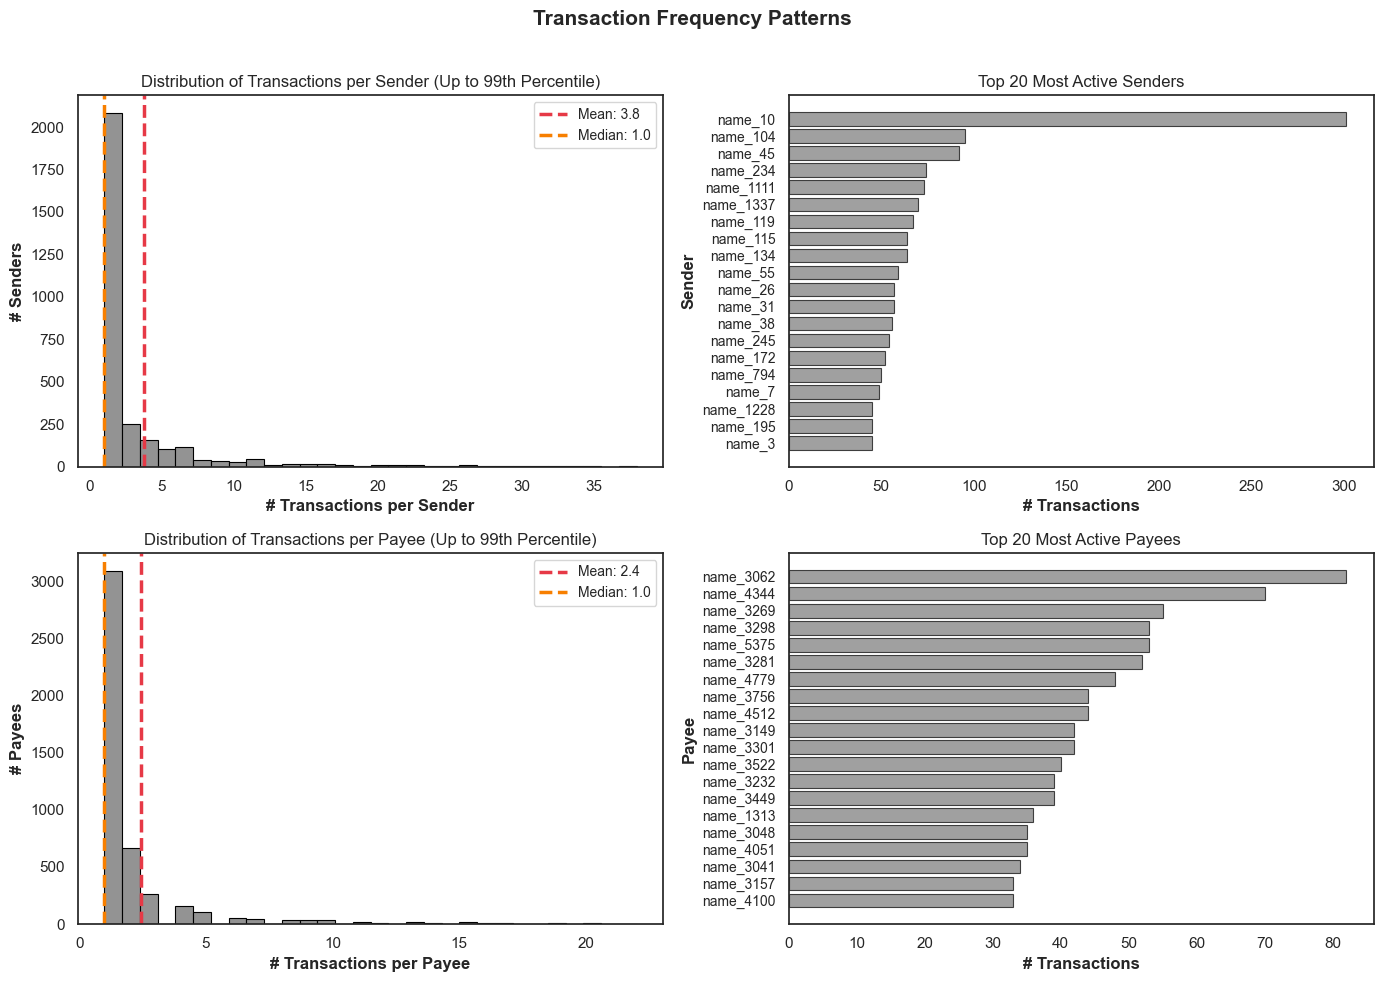


Sender Frequency Statistics:
count    3018.000000
mean        3.773360
std         8.862874
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max       301.000000
dtype: float64

Payee Frequency Statistics:
count    4655.000000
mean        2.446402
std         4.419999
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        82.000000
dtype: float64

Observations:
  - Sender 'name_10' had the most sender transactions (301)
  - Number of senders with exactly one transaction: 1592
  - Percentage of senders with exactly one transaction: 52.75%
  - Payee 'name_3062' had the most payee transactions (82)
  - Number of payees with exactly one transaction: 3092
  - Percentage of payees with exactly one transaction: 66.42%


In [549]:
sender_txn_counts = df_copy.groupby('Sender Name').size()
payee_txn_counts = df_copy.groupby('Payee Name').size()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Transaction Frequency Patterns', fontsize=15, fontweight='bold')

# Plot 1: Sender distribution
mean_sender = sender_txn_counts.mean()
median_sender = sender_txn_counts.median()
sender_distribution = sender_txn_counts[sender_txn_counts <= sender_txn_counts.quantile(0.99)]

sns.histplot(sender_distribution, bins=30, edgecolor='black', alpha=0.8,
             color='#787878', linewidth=0.8, ax=axes[0, 0])

axes[0, 0].axvline(mean_sender, color='#E63946', linestyle='--', linewidth=2.5, 
                   label=f'Mean: {mean_sender:.1f}')
axes[0, 0].axvline(median_sender, color='#F77F00', linestyle='--', linewidth=2.5, 
                   label=f'Median: {median_sender:.1f}')

axes[0, 0].set_xlabel('# Transactions per Sender', fontweight='bold')
axes[0, 0].set_ylabel('# Senders', fontweight='bold')
axes[0, 0].set_title('Distribution of Transactions per Sender (Up to 99th Percentile)', fontsize=12)
axes[0, 0].legend(fontsize=10)

# Plot 2: Top 20 senders
top_senders = sender_txn_counts.nlargest(20)

axes[0, 1].barh(range(len(top_senders)), top_senders.values, color='#787878',edgecolor='black', linewidth=0.8, alpha=0.7)
axes[0, 1].set_yticks(range(len(top_senders)))
axes[0, 1].set_yticklabels(top_senders.index, fontsize=10)
axes[0, 1].set_xlabel('# Transactions', fontweight='bold')
axes[0, 1].set_ylabel('Sender', fontweight='bold')
axes[0, 1].set_title('Top 20 Most Active Senders', fontsize=12)
axes[0, 1].invert_yaxis()

# Plot 3: Payee distribution
mean_payee = payee_txn_counts.mean()
median_payee = payee_txn_counts.median()
payee_distribution = payee_txn_counts[payee_txn_counts <= payee_txn_counts.quantile(0.99)]

sns.histplot(payee_distribution, bins=30, edgecolor='black', alpha=0.8,
             color='#787878', linewidth=0.8, ax=axes[1, 0])

axes[1, 0].axvline(mean_payee, color='#E63946', linestyle='--', linewidth=2.5, 
                   label=f'Mean: {mean_payee:.1f}')
axes[1, 0].axvline(median_payee, color='#F77F00', linestyle='--', linewidth=2.5, 
                   label=f'Median: {median_payee:.1f}')

axes[1, 0].set_xlabel('# Transactions per Payee', fontweight='bold')
axes[1, 0].set_ylabel('# Payees', fontweight='bold')
axes[1, 0].set_title('Distribution of Transactions per Payee (Up to 99th Percentile)', fontsize=12)
axes[1, 0].legend(fontsize=10)

# Plot 4: Top 20 payees
top_payees = payee_txn_counts.nlargest(20)

axes[1, 1].barh(range(len(top_payees)), top_payees.values, color='#787878',
                edgecolor='black', linewidth=0.8, alpha=0.7)

axes[1, 1].set_yticks(range(len(top_payees)))
axes[1, 1].set_yticklabels(top_payees.index, fontsize=10)
axes[1, 1].set_xlabel('# Transactions', fontweight='bold')
axes[1, 1].set_ylabel('Payee', fontweight='bold')
axes[1, 1].set_title('Top 20 Most Active Payees', fontsize=12)
axes[1, 1].invert_yaxis()

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

# Quick summary
print("\nSender Frequency Statistics:")
print(sender_txn_counts.describe())

print("\nPayee Frequency Statistics:")
print(payee_txn_counts.describe())

print("\nObservations:")
print(f"  - Sender '{sender_txn_counts.idxmax()}' had the most sender transactions ({sender_txn_counts.max()})")

num_single_txn_senders = (sender_txn_counts == 1).sum()
print(f"  - Number of senders with exactly one transaction: {num_single_txn_senders}")
print(f"  - Percentage of senders with exactly one transaction: {num_single_txn_senders / len(sender_txn_counts) * 100:.2f}%")
print(f"  - Payee '{payee_txn_counts.idxmax()}' had the most payee transactions ({payee_txn_counts.max()})")

num_single_txn_payees = (payee_txn_counts == 1).sum()
print(f"  - Number of payees with exactly one transaction: {num_single_txn_payees}")
print(f"  - Percentage of payees with exactly one transaction: {num_single_txn_payees / len(payee_txn_counts) * 100:.2f}%")

#### Temporal Patterns

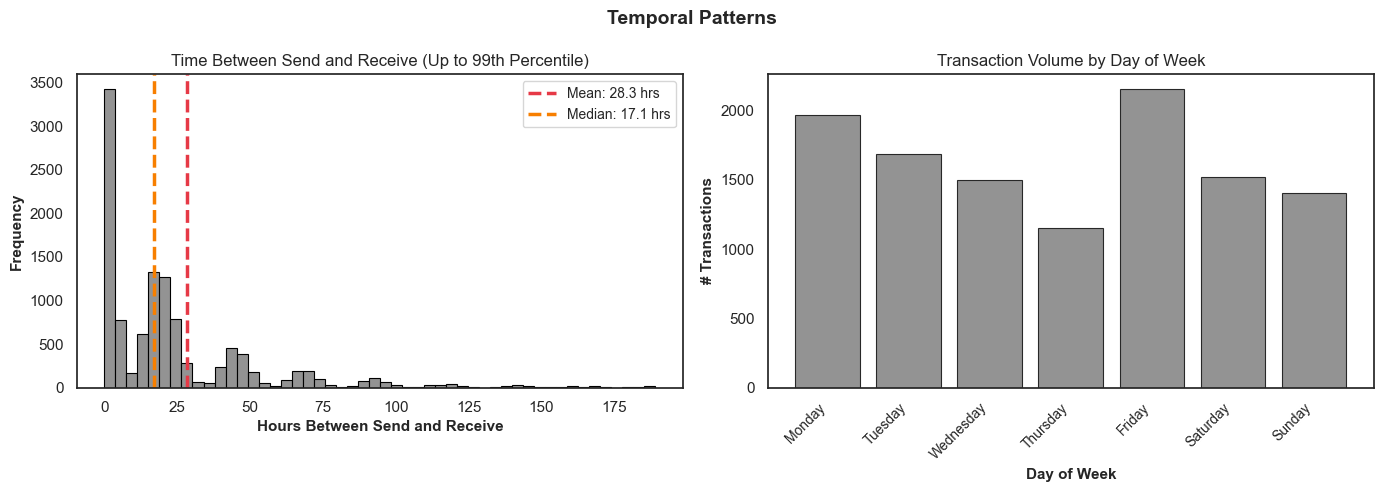


Time Between Send and Receive Statistics:
count    11388.000000
mean        28.270315
std        161.545612
min          0.000000
25%          2.683333
50%         17.108333
75%         28.466667
max      16473.183333
Name: Time Between Send Pay (hours), dtype: float64

Observations:
  - Transactions received < 1 hour: 1,336 (11.7%)
  - Same-day transactions: 4,282 (37.6%)
  - Transactions with > 7 day delay: 145 (1.3%)
  - On average, transactions are received in a little over a day of being sent
  - Transaction volume varies significantly by day of week, peaking on Friday


In [550]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Temporal Patterns', fontsize=14, fontweight='bold')

# Plot 1: Distribution of time between send and receive
mean_time = df_copy['Time Between Send Pay (hours)'].mean()
median_time = df_copy['Time Between Send Pay (hours)'].median()
p99_time = df_copy['Time Between Send Pay (hours)'].quantile(0.99)
time_distribution = df_copy[df_copy['Time Between Send Pay (hours)'] <= p99_time]

sns.histplot(time_distribution['Time Between Send Pay (hours)'], bins=50, 
             edgecolor='black', alpha=0.8, color='#787878', ax=axes[0], linewidth=0.8)
axes[0].axvline(mean_time, color='#E63946', linestyle='--', linewidth=2.5, 
                label=f'Mean: {mean_time:.1f} hrs')
axes[0].axvline(median_time, color='#F77F00', linestyle='--', linewidth=2.5, 
                label=f'Median: {median_time:.1f} hrs')
axes[0].set_xlabel('Hours Between Send and Receive', fontweight='bold', fontsize=11)
axes[0].set_ylabel('Frequency', fontweight='bold', fontsize=11)
axes[0].set_title(f'Time Between Send and Receive (Up to 99th Percentile)', fontsize=12)
axes[0].legend(fontsize=10)

# Plot 2: Transaction volume by day of week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts = df_copy['Send Day of Week'].value_counts().reindex(day_order)

axes[1].bar(range(len(day_counts)), day_counts.values, color='#787878', 
            edgecolor='black', linewidth=0.8, alpha=0.8)
axes[1].set_xticks(range(len(day_counts)))
axes[1].set_xticklabels(day_counts.index, rotation=45, ha='right', fontsize=10)
axes[1].set_xlabel('Day of Week', fontweight='bold', fontsize=11)
axes[1].set_ylabel('# Transactions', fontweight='bold', fontsize=11)
axes[1].set_title('Transaction Volume by Day of Week', fontsize=12)

plt.tight_layout()
plt.show()

# Quick summary
quick_turnaround = df_copy[df_copy['Time Between Send Pay (hours)'] < 1]
same_day = df_copy[df_copy['Send DateTime'].dt.date == df_copy['Pay DateTime'].dt.date]
long_delay = df_copy[df_copy['Time Between Send Pay (hours)'] > 168]  # > 7 days

print(f"\nTime Between Send and Receive Statistics:")
print(df_copy['Time Between Send Pay (hours)'].describe())

print("\nObservations:")
print(f"  - Transactions received < 1 hour: {len(quick_turnaround):,} ({len(quick_turnaround)/len(df_copy)*100:.1f}%)")
print(f"  - Same-day transactions: {len(same_day):,} ({len(same_day)/len(df_copy)*100:.1f}%)")
print(f"  - Transactions with > 7 day delay: {len(long_delay):,} ({len(long_delay)/len(df_copy)*100:.1f}%)")
print("  - On average, transactions are received in a little over a day of being sent")
print("  - Transaction volume varies significantly by day of week, peaking on Friday")

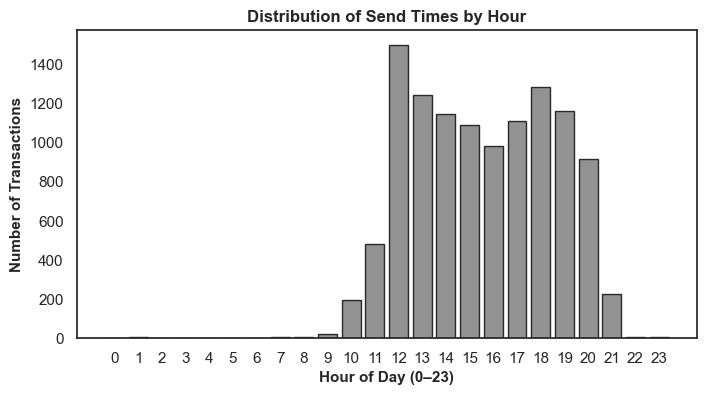


Observations:
  - Transactions are most common between 12 PM and 8 PM
  - Why would a flower shop be so active at night? It's not necessarily an indication of money laundering, but it's definitely unusual.


In [551]:
# Plot 3: Distribution of send times by hour
plt.figure(figsize=(8,4))

hour_counts = df_copy['Send Hour'].value_counts().sort_index()
hours = hour_counts.index
counts = hour_counts.values

plt.bar(hours, counts, color='#787878', edgecolor='black', alpha=0.8)
plt.title('Distribution of Send Times by Hour', fontsize=12, fontweight='bold')
plt.xlabel('Hour of Day (0–23)', fontsize=11, fontweight='bold')
plt.ylabel('Number of Transactions', fontsize=11, fontweight='bold')
plt.xticks(range(24))

plt.show()

print("\nObservations:")
print("  - Transactions are most common between 12 PM and 8 PM")
print("  - Why would a flower shop be so active at night? It's not necessarily an indication of money laundering, but it's definitely unusual.")

#### Send & Pay Agent Patterns

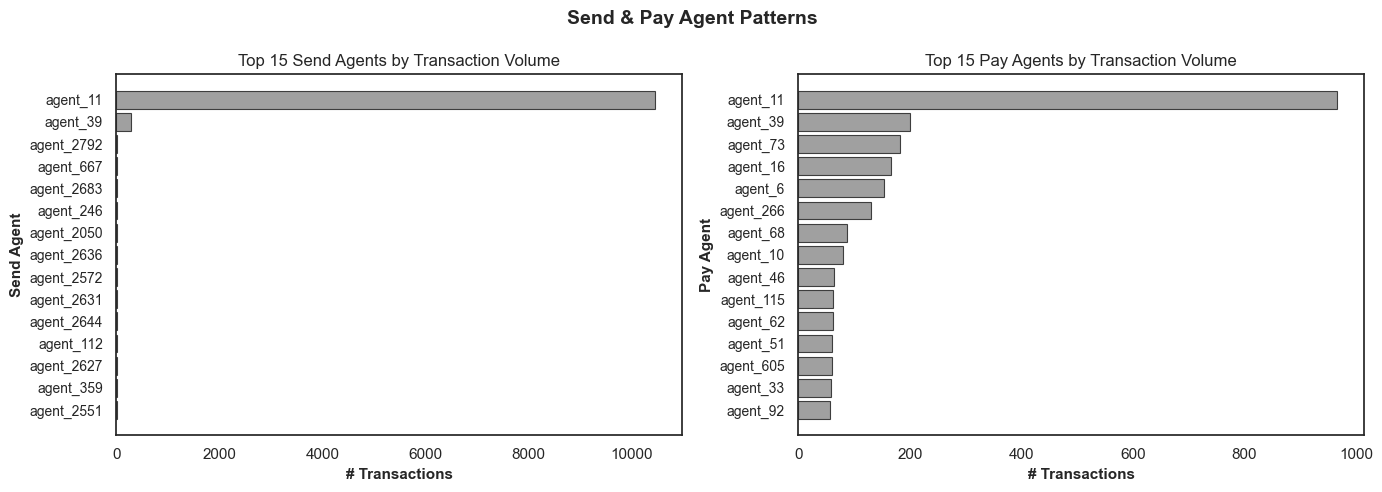


Send Agent Statistics:
  - Unique send agents: 398
  - Most used send agent: agent_11 (10,457 transactions)
  - Transactions at top agent: 91.8% of total

Pay Agent Statistics:
  - Unique pay agents: 2518
  - Most used pay agent: agent_11 (966 transactions)


In [552]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Send & Pay Agent Patterns', fontsize=14, fontweight='bold')

# Plot 1: Top 15 send agents
send_agent_counts = df_copy['Send Agent Name'].value_counts()
top_send_agents = send_agent_counts.head(15)

axes[0].barh(range(len(top_send_agents)), top_send_agents.values, color='#787878', 
             edgecolor='black', linewidth=0.8, alpha=0.7)
axes[0].set_yticks(range(len(top_send_agents)))
axes[0].set_yticklabels([f'{name}' for name in top_send_agents.index], fontsize=10)
axes[0].set_ylabel('Send Agent', fontweight='bold', fontsize=11)
axes[0].set_xlabel('# Transactions', fontweight='bold', fontsize=11)
axes[0].set_title('Top 15 Send Agents by Transaction Volume', fontsize=12)
axes[0].invert_yaxis()

# Plot 2: Top 15 pay agents
pay_agent_counts = df_copy['Pay Agent Name'].value_counts()
top_pay_agents = pay_agent_counts.head(15)

axes[1].barh(range(len(top_pay_agents)), top_pay_agents.values, color='#787878', 
             edgecolor='black', linewidth=0.8, alpha=0.7)
axes[1].set_yticks(range(len(top_pay_agents)))
axes[1].set_yticklabels([f'{name}' for name in top_pay_agents.index], fontsize=10)
axes[1].set_ylabel('Pay Agent', fontweight='bold', fontsize=11)
axes[1].set_xlabel('# Transactions', fontweight='bold', fontsize=11)
axes[1].set_title('Top 15 Pay Agents by Transaction Volume', fontsize=12)
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

print(f"\nSend Agent Statistics:")
print(f"  - Unique send agents: {df_copy['Send Agent Name'].nunique()}")
print(f"  - Most used send agent: {send_agent_counts.index[0]} ({send_agent_counts.iloc[0]:,} transactions)")
print(f"  - Transactions at top agent: {send_agent_counts.iloc[0]/len(df_copy)*100:.1f}% of total")

print(f"\nPay Agent Statistics:")
print(f"  - Unique pay agents: {df_copy['Pay Agent Name'].nunique()}")
print(f"  - Most used pay agent: {pay_agent_counts.index[0]} ({pay_agent_counts.iloc[0]:,} transactions)")

#### Geographic Patterns

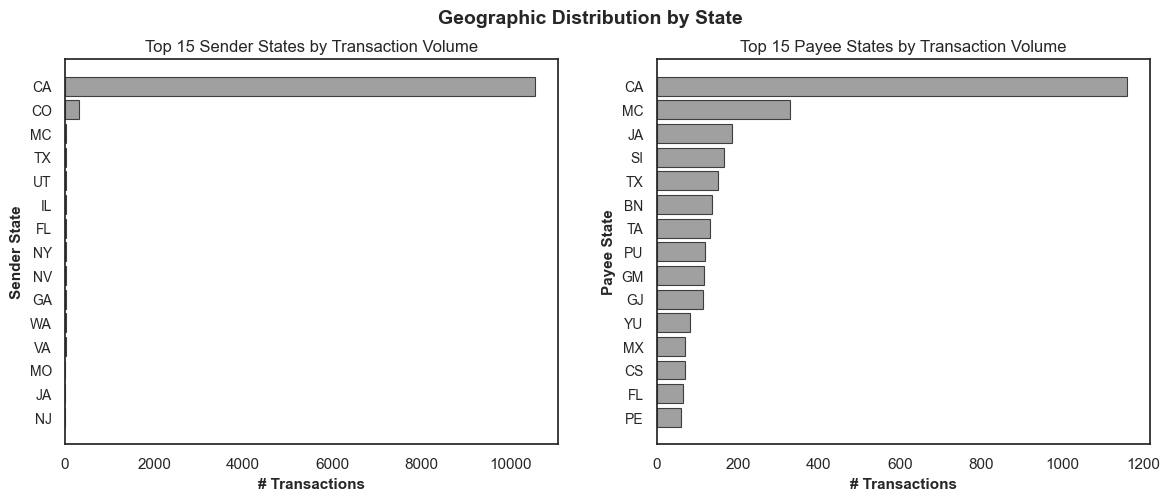

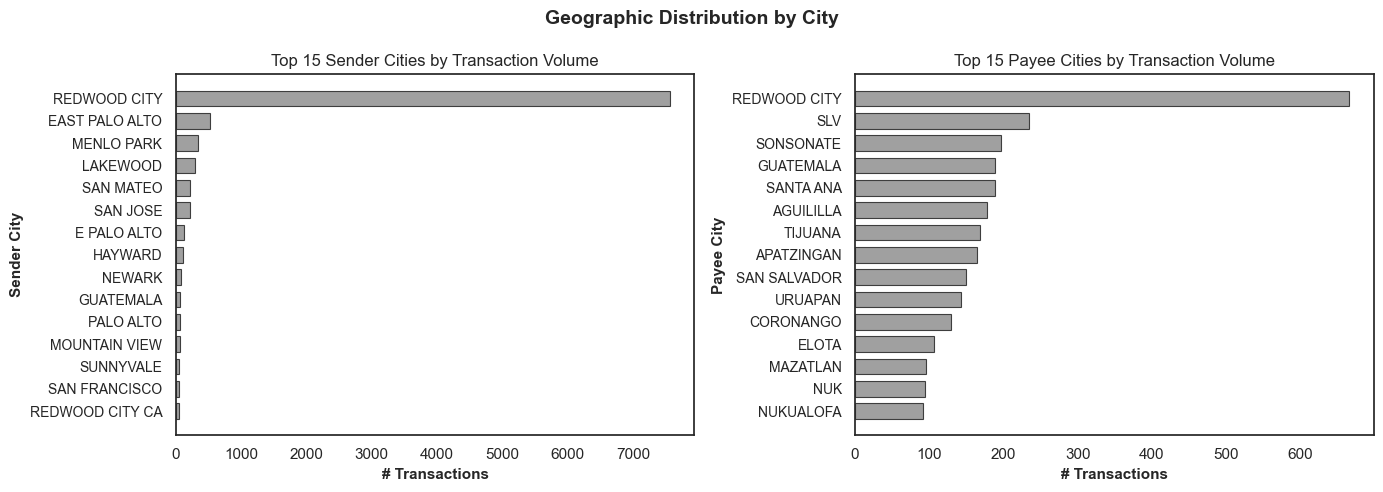

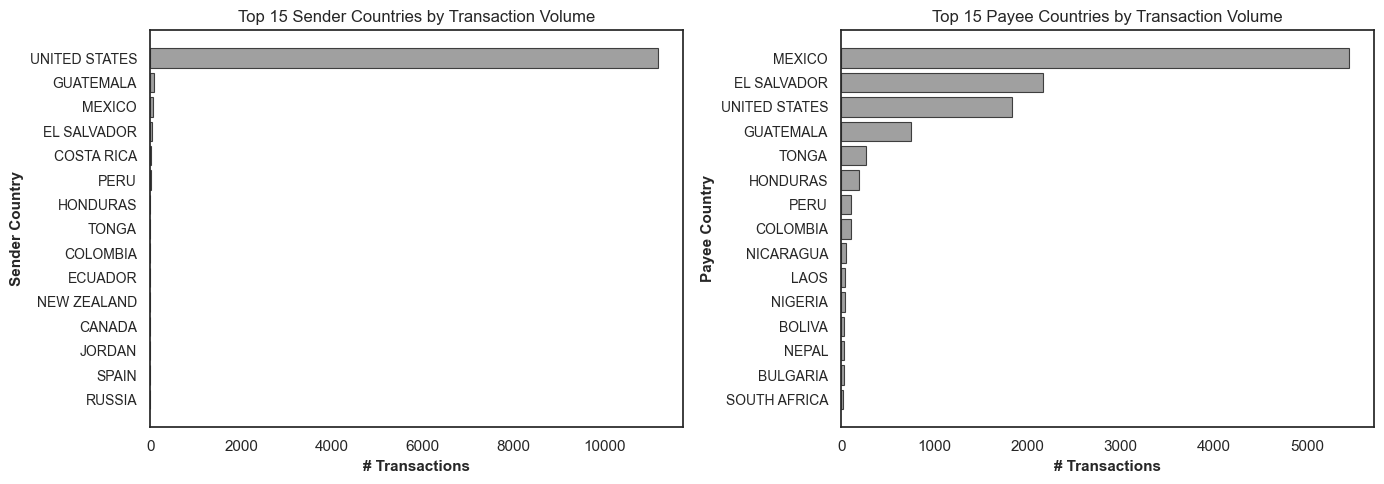

In [553]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Geographic Distribution by State', fontsize=14, fontweight='bold')

# Plot 1: Geographic distribution by state
sender_state_counts = df_copy['Sender State'].value_counts()
top_sender_states = sender_state_counts.head(15)
axes[0].barh(range(len(top_sender_states)), top_sender_states.values, color='#787878', 
             edgecolor='black', linewidth=0.8, alpha=0.7)
axes[0].set_yticks(range(len(top_sender_states)))
axes[0].set_yticklabels([f'{state}' for state in top_sender_states.index], fontsize=10)
axes[0].set_ylabel('Sender State', fontweight='bold', fontsize=11)
axes[0].set_xlabel('# Transactions', fontweight='bold', fontsize=11)
axes[0].set_title('Top 15 Sender States by Transaction Volume', fontsize=12)
axes[0].invert_yaxis()

# Plot 2: Top 15 payee states by transaction volume
payee_state_counts = df_copy['Payee State'].value_counts()
top_payee_states = payee_state_counts.head(15)
axes[1].barh(range(len(top_payee_states)), top_payee_states.values, color='#787878', 
             edgecolor='black', linewidth=0.8, alpha=0.7)
axes[1].set_yticks(range(len(top_payee_states)))
axes[1].set_yticklabels([f'{state}' for state in top_payee_states.index], fontsize=10)
axes[1].set_ylabel('Payee State', fontweight='bold', fontsize=11)
axes[1].set_xlabel('# Transactions', fontweight='bold', fontsize=11)
axes[1].set_title('Top 15 Payee States by Transaction Volume', fontsize=12)
axes[1].invert_yaxis()

# Plot 3: Top 15 sender cities by transaction volume
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Geographic Distribution by City', fontsize=14, fontweight='bold')

sender_city_counts = df_copy['Sender City'].value_counts()
top_sender_cities = sender_city_counts.head(15)
axes[0].barh(range(len(top_sender_cities)), top_sender_cities.values, color='#787878', 
             edgecolor='black', linewidth=0.8, alpha=0.7, height=0.7)
axes[0].set_yticks(range(len(top_sender_cities)))
axes[0].set_yticklabels([f'{city}' for city in top_sender_cities.index], fontsize=10)
axes[0].set_ylabel('Sender City', fontweight='bold', fontsize=11)
axes[0].set_xlabel('# Transactions', fontweight='bold', fontsize=11)
axes[0].set_title('Top 15 Sender Cities by Transaction Volume', fontsize=12)
axes[0].invert_yaxis()

# Plot 4: Top 15 payee cities by transaction volume
payee_city_counts = df_copy['Payee City'].value_counts()
top_payee_cities = payee_city_counts.head(15)
axes[1].barh(range(len(top_payee_cities)), top_payee_cities.values, color='#787878', 
             edgecolor='black', linewidth=0.8, alpha=0.7, height=0.7)
axes[1].set_yticks(range(len(top_payee_cities)))
axes[1].set_yticklabels([f'{city}' for city in top_payee_cities.index], fontsize=10)
axes[1].set_ylabel('Payee City', fontweight='bold', fontsize=11)
axes[1].set_xlabel('# Transactions', fontweight='bold', fontsize=11)
axes[1].set_title('Top 15 Payee Cities by Transaction Volume', fontsize=12)
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

# Plot 5: Top 15 sender countries by transaction volume
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sender_country_counts = df_copy['Send Country'].value_counts()
top_sender_countries = sender_country_counts.head(15)
axes[0].barh(range(len(top_sender_countries)), top_sender_countries.values, color='#787878', 
             edgecolor='black', linewidth=0.8, alpha=0.7)
axes[0].set_yticks(range(len(top_sender_countries)))
axes[0].set_yticklabels([f'{country}' for country in top_sender_countries.index], fontsize=10)
axes[0].set_ylabel('Sender Country', fontweight='bold', fontsize=11)
axes[0].set_xlabel('# Transactions', fontweight='bold', fontsize=11)
axes[0].set_title('Top 15 Sender Countries by Transaction Volume', fontsize=12)
axes[0].invert_yaxis()

# Plot 6: Top 15 payee countries by transaction volume
payee_country_counts = df_copy['Pay Country'].value_counts()
top_payee_countries = payee_country_counts.head(15)
axes[1].barh(range(len(top_payee_countries)), top_payee_countries.values, color='#787878', 
             edgecolor='black', linewidth=0.8, alpha=0.7)
axes[1].set_yticks(range(len(top_payee_countries)))
axes[1].set_yticklabels([f'{country}' for country in top_payee_countries.index], fontsize=10)
axes[1].set_ylabel('Payee Country', fontweight='bold', fontsize=11)
axes[1].set_xlabel('# Transactions', fontweight='bold', fontsize=11)
axes[1].set_title('Top 15 Payee Countries by Transaction Volume', fontsize=12)
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

#### Other Notable Insights

In [554]:
# Suspicious self transfers
self_transfers = df_copy['Sender Name'].str.lower().str.strip() == df_copy['Payee Name'].str.strip()
print(f"{self_transfers.sum()} people transferred money to themselves!")

# Maximum ages
print(f"\nThe maximum sender age is {df_copy['Sender Age'].max()}, while the maximum payee age is {df_copy['Payee Age'].max()}")
print("For reference, the age of the oldest person ever recorded is 122...")

# Invalid ages
print(f"\nThere are {df_copy['Sender Age'][df_copy['Sender Age'] < 18].count()} payees below age 18, as young as {df_copy['Payee Age'].min()}!")
print("Note that wire transfers are not legal for minors.")

# Average transaction amount across the 20 most active senders
top_sender_names = top_senders.index
avg_amount_top_senders = df_copy[df_copy['Sender Name'].isin(top_sender_names)]['Amount'].mean()
print(f"\nAverage transaction amount across the 20 most active senders: {avg_amount_top_senders:.2f}")

# Average transaction amount across the 20 most active payees
top_payee_names = top_payees.index
avg_amount_top_payees = df_copy[df_copy['Payee Name'].isin(top_payee_names)]['Amount'].mean()
print(f"Average transaction amount across the 20 most active payees: {avg_amount_top_payees:.2f}")


99 people transferred money to themselves!

The maximum sender age is 121.0, while the maximum payee age is 121.0
For reference, the age of the oldest person ever recorded is 122...

There are 0 payees below age 18, as young as 12.0!
Note that wire transfers are not legal for minors.

Average transaction amount across the 20 most active senders: 855.49
Average transaction amount across the 20 most active payees: 806.47


### 1.3 Hypothesis Development
**Objective:** Identify potential indicators of money laundering based on my EDA and AML best practices.

#### Hypothesis 1: International Money Laundering from USA to Mexico

**Hypothesis**: The overwhelming concentration of transactions flowing from the United States (specifically California) to Mexico indicates a systematic cross-border money laundering operation designed to repatriate illicit proceeds to cartel-controlled territories.

**Why this might indicate suspicious behavior:** A mostly one-way flow of transactions from the United States to Mexico, with minimal reverse traffic, is inconsistent with legitimate business operations involving two-way commerce. A legitimate flower shop would not reasonable conduct thousands of international wire transfers.

**Reference:** FinCEN suggests geographic patterns as key money laundering indicators, suggesting that cartels utilize "Black Market Peso Exchange" (BMPE) schemes to manuver around currency requirements which impede laundering schemes [(Source)](https://www.fincen.gov/system/files/advisory/advisu9.pdf).


#### Hypothesis 2: Suspicious Send Agent Concentration Suggests Laundering

**Hypothesis**: A disproportionately high volume of transactions originating from a single send agent location indicates that the business is being used as a money laundering front or facilitating point for illicit transactions.

**Why this might indicate suspicious behavior:** Money laundering operations often involve complicit businesses that serve as processing centers for large volumes of structured transactions. When a single physical location accounts for an unusually high percentage of all transactions, it suggests that the location is involved in money laundering.

**Reference:**
FinCEN requires MSBs to report suspicious patterns of transactions, such as activity with no apparent lawful business purpose or that may be structured to evade BSA requirements ([Source](https://www.fincen.gov/money-services-business-msb-suspicious-activity-reporting)). Since this business is a flower shop and likely not registered as an MSB, high money-transfer volume is even more suspicious.

#### Hypothesis 3: High Frequency Senders/Payees Indicate Structuring

**Hypothesis**: A small number of senders or payees conducting an unusually high number of transfers indicates potential structuring.

**Why this might indicate suspicious behavior:** By conducting hundreds of transactions over time rather than fewer large transfers, malicious individuals can keep each transaction below reporting thresholds whie sitll moving substantial amounts of money. A flower shop would not reasonably have customers or suppliers conducting 800+ individual money transfers in a year.

**Reference:** FinCEN states that "structuring is the breaking up of transactions for the purpose of evading the Bank Secrecy Act reporting and recordkeeping requirements," and that it can take a primary basic form: a single customer transacting currency over multiple days in split amounts that, when summed, would otherwise total to a number that requires reporting ([Source](https://www.fincen.gov/resources/statutes-regulations/administrative-rulings/suspicious-activity-reporting-structuring)).

## Part 2: Hypothesis Testing & Write-Up

### 2.1: Testing Hypotheses

### Test 1: International Money Laundering from USA to Mexico

In [555]:
us_to_mexico = df_copy[(df_copy['Send Country'] == 'UNITED STATES') & (df_copy['Pay Country'] == 'MEXICO')]
mexico_to_us = df_copy[(df_copy['Send Country'] == 'MEXICO') & (df_copy['Pay Country'] == 'UNITED STATES')]

print(f"\nCross-Border Flow:")
print(f"  - US -> Mexico: {len(us_to_mexico):,} transactions (${us_to_mexico['Amount'].sum():,.2f})")
print(f"  - Mexico -> US: {len(mexico_to_us):,} transactions (${mexico_to_us['Amount'].sum():,.2f})")
print(f"  - Flow ratio: {len(us_to_mexico) / max(len(mexico_to_us), 1):.1f}x more US -> Mexico")

ca_to_mexico = df_copy[(df_copy['Sender State'] == 'CA') & (df_copy['Pay Country'] == 'MEXICO')]
print(f"\nCalifornia Concentration:")
print(f"  - {len(ca_to_mexico):,} transactions from CA to Mexico ({len(ca_to_mexico)/len(us_to_mexico)*100:.1f}% of US -> Mexico flow)")
print(f"  - Total amount: ${ca_to_mexico['Amount'].sum():,.2f}")

# Identify suspects
us_to_mexico_senders = us_to_mexico.groupby('Sender Name').size().sort_values(ascending=False)
us_to_mexico_payees = us_to_mexico.groupby('Payee Name').size().sort_values(ascending=False)

threshold = 20
suspects_senders = us_to_mexico_senders[us_to_mexico_senders >= threshold]
suspects_payees = us_to_mexico_payees[us_to_mexico_payees >= threshold]

print(f"\nSuspect Identification (20+ cross-border transactions):")
print(f"\nSuspicious Senders ({len(suspects_senders)} total, 10 shown):")
for i, (sender, count) in enumerate(suspects_senders.head(10).items(), 1):
    total = us_to_mexico[us_to_mexico['Sender Name'] == sender]['Amount'].sum()
    print(f"  {i}. {sender}: {count} txns, ${total:,.2f}")

print(f"\nSuspicious Payees ({len(suspects_payees)} total, 10 shown):")
for i, (payee, count) in enumerate(suspects_payees.head(10).items(), 1):
    total = us_to_mexico[us_to_mexico['Payee Name'] == payee]['Amount'].sum()
    print(f"  {i}. {payee}: {count} txns, ${total:,.2f}")

print(f"\nConclusion: Unidirectional US→Mexico flow consistent with money laundering scheme")

suspicious_mexico_sender_list = list(suspects_senders.index)
suspicious_mexico_payee_list = list(suspects_payees.index)


Cross-Border Flow:
  - US -> Mexico: 5,449 transactions ($4,702,322.73)
  - Mexico -> US: 59 transactions ($50,231.93)
  - Flow ratio: 92.4x more US -> Mexico

California Concentration:
  - 5,408 transactions from CA to Mexico (99.2% of US -> Mexico flow)
  - Total amount: $4,664,781.73

Suspect Identification (20+ cross-border transactions):

Suspicious Senders (59 total, 10 shown):
  1. name_104: 95 txns, $84,455.00
  2. name_234: 74 txns, $72,550.00
  3. name_1111: 70 txns, $54,845.00
  4. name_115: 64 txns, $35,900.00
  5. name_55: 59 txns, $43,012.00
  6. name_31: 57 txns, $50,452.00
  7. name_172: 52 txns, $43,448.00
  8. name_794: 50 txns, $26,550.00
  9. name_38: 47 txns, $43,092.00
  10. name_3: 45 txns, $34,539.01

Suspicious Payees (34 total, 10 shown):
  1. name_4344: 70 txns, $54,845.00
  2. name_3269: 55 txns, $54,180.00
  3. name_5375: 53 txns, $51,145.00
  4. name_3281: 52 txns, $51,280.00
  5. name_4512: 44 txns, $33,730.00
  6. name_3301: 42 txns, $42,000.00
  7. nam

### Test 2: Suspicious Send Agent Concentration Suggests Laundering

In [556]:
send_agent_counts = df_copy['Send Agent Name'].value_counts()
top_agent = send_agent_counts.index[0]
top_agent_txns = send_agent_counts.iloc[0]

print(f"\nAgent Concentration:")
print(f"  - Top agent: {top_agent}")
print(f"  - Transactions: {top_agent_txns:,} ({top_agent_txns/len(df_copy)*100:.1f}% of all transactions)")
print(f"  - Next highest agent: {send_agent_counts.iloc[1]:,} transactions")
print(f"  - Concentration: {top_agent_txns/send_agent_counts.iloc[1]:.1f}x more than 2nd place")

agent_txns = df_copy[df_copy['Send Agent Name'] == top_agent]
print(f"\nActivity at {top_agent}:")
print(f"  - Total amount processed: ${agent_txns['Amount'].sum():,.2f}")
print(f"  - Average transaction: ${agent_txns['Amount'].mean():.2f}")
print(f"  - Unique senders: {agent_txns['Sender Name'].nunique()}")
print(f"  - Unique payees: {agent_txns['Payee Name'].nunique()}")

# Identify suspects using this agent
agent_senders = agent_txns.groupby('Sender Name').size().sort_values(ascending=False)
agent_payees = agent_txns.groupby('Payee Name').size().sort_values(ascending=False)

threshold = 50
suspects_at_agent_senders = agent_senders[agent_senders >= threshold]
suspects_at_agent_payees = agent_payees[agent_payees >= threshold]

print(f"\nSuspicious Senders ({len(suspects_at_agent_senders)} total, 10 shown):")
for i, (sender, count) in enumerate(suspects_at_agent_senders.head(10).items(), 1):
    total = agent_txns[agent_txns['Sender Name'] == sender]['Amount'].sum()
    print(f"  {i}. {sender}: {count} txns, ${total:,.2f}")

print(f"\nSuspicious Payees ({len(suspects_at_agent_payees)} total, all shown):")
for i, (payee, count) in enumerate(suspects_at_agent_payees.head(10).items(), 1):
    total = agent_txns[agent_txns['Payee Name'] == payee]['Amount'].sum()
    print(f"  {i}. {payee}: {count} txns, ${total:,.2f}")

print(f"\nConclusion: {top_agent} concentration indicates complicit business facilitating money laundering")

suspicious_agent_sender_list = list(suspects_at_agent_senders.index)
suspicious_agent_payee_list = list(suspects_at_agent_payees.index)


Agent Concentration:
  - Top agent: agent_11
  - Transactions: 10,457 (91.8% of all transactions)
  - Next highest agent: 291 transactions
  - Concentration: 35.9x more than 2nd place

Activity at agent_11:
  - Total amount processed: $9,407,641.57
  - Average transaction: $899.65
  - Unique senders: 2578
  - Unique payees: 4031

Suspicious Senders (15 total, 10 shown):
  1. name_104: 95 txns, $84,455.00
  2. name_45: 92 txns, $60,645.00
  3. name_234: 74 txns, $72,550.00
  4. name_1111: 73 txns, $57,235.00
  5. name_1337: 70 txns, $47,872.60
  6. name_119: 67 txns, $53,945.00
  7. name_115: 64 txns, $35,900.00
  8. name_134: 64 txns, $48,292.00
  9. name_55: 59 txns, $43,012.00
  10. name_26: 57 txns, $36,165.00

Suspicious Payees (6 total, all shown):
  1. name_3062: 82 txns, $53,855.00
  2. name_4344: 70 txns, $54,845.00
  3. name_3269: 55 txns, $54,180.00
  4. name_3298: 53 txns, $33,155.00
  5. name_5375: 53 txns, $51,145.00
  6. name_3281: 52 txns, $51,280.00

Conclusion: agent_

### Test 3: High Frequency Senders/Payees Indicate Structuring

In [557]:
sender_txn_counts = df_copy.groupby('Sender Name').size().sort_values(ascending=False)
payee_txn_counts = df_copy.groupby('Payee Name').size().sort_values(ascending=False)

print(f"\nTransaction Frequency Distribution:")
print(f"  - Total unique senders: {len(sender_txn_counts)}")
print(f"  - Total unique payees: {len(payee_txn_counts)}")
print(f"  - Senders with 1 transaction: {(sender_txn_counts == 1).sum()} ({(sender_txn_counts == 1).sum()/len(sender_txn_counts)*100:.1f}%)")
print(f"  - Payees with 1 transaction: {(payee_txn_counts == 1).sum()} ({(payee_txn_counts == 1).sum()/len(payee_txn_counts)*100:.1f}%)")

# Top structurers
top_sender = sender_txn_counts.index[0]
top_sender_count = sender_txn_counts.iloc[0]
top_sender_total = df_copy[df_copy['Sender Name'] == top_sender]['Amount'].sum()
top_sender_avg = top_sender_total / top_sender_count

top_payee = payee_txn_counts.index[0]
top_payee_count = payee_txn_counts.iloc[0]
top_payee_total = df_copy[df_copy['Payee Name'] == top_payee]['Amount'].sum()
top_payee_avg = top_payee_total / top_payee_count

print(f"\nMost Active Structurers:")
print(f"  - Top sender: {top_sender}")
print(f"    - {top_sender_count:,} transactions, ${top_sender_total:,.2f} total, ${top_sender_avg:.2f} avg")
print(f"  - Top payee: {top_payee}")
print(f"    - {top_payee_count:,} transactions, ${top_payee_total:,.2f} total, ${top_payee_avg:.2f} avg")

# Identify all suspects with structuring behavior
threshold = 100
suspects_structuring_senders = sender_txn_counts[sender_txn_counts >= threshold]
suspects_structuring_payees = payee_txn_counts[payee_txn_counts >= threshold]

print(f"\nTotal Suspects with 100+ transactions:")
print(f"  - Senders: {len(suspects_structuring_senders)}")
print(f"  - Payees: {len(suspects_structuring_payees)}")

print(f"\nConclusion: High-frequency individuals are breaking up large amounts into many small transactions to evade reporting")

suspicious_sender_list_structuring = list(suspects_structuring_senders.index)
suspicious_payee_list_structuring = list(suspects_structuring_payees.index)


Transaction Frequency Distribution:
  - Total unique senders: 3018
  - Total unique payees: 4655
  - Senders with 1 transaction: 1592 (52.8%)
  - Payees with 1 transaction: 3092 (66.4%)

Most Active Structurers:
  - Top sender: name_10
    - 301 transactions, $370,671.15 total, $1231.47 avg
  - Top payee: name_3062
    - 82 transactions, $53,855.00 total, $656.77 avg

Total Suspects with 100+ transactions:
  - Senders: 1
  - Payees: 0

Conclusion: High-frequency individuals are breaking up large amounts into many small transactions to evade reporting


### Collect & Rank Final Suspects

In [558]:
suspect_lists = [
    suspicious_mexico_payee_list,
    suspicious_mexico_sender_list,
    suspicious_agent_payee_list,
    suspicious_agent_sender_list,
    suspicious_sender_list_structuring,
    suspicious_payee_list_structuring,
]

all_suspects = []
for suspect_list in suspect_lists:
    all_suspects.extend(suspect_list)
suspect_counts = Counter(all_suspects)

top_suspects = [name for name, count in suspect_counts.items() if count >= 2]
standard_suspects = [name for name, count in suspect_counts.items() if count == 1]

print(f"Total suspects: {len(all_suspects)}")
print(f"\nTop suspects (flagged in >=2 tests) ({len(top_suspects)} total):\n{top_suspects}")
print(f"\nAll other suspects: ({len(standard_suspects)} total):\n{standard_suspects}")

Total suspects: 115

Top suspects (flagged in >=2 tests) (14 total):
['name_4344', 'name_3269', 'name_5375', 'name_3281', 'name_2285', 'name_104', 'name_234', 'name_1111', 'name_115', 'name_55', 'name_31', 'name_172', 'name_794', 'name_38']

All other suspects: (87 total):
['name_4512', 'name_3301', 'name_3232', 'name_3449', 'name_4051', 'name_3048', 'name_3041', 'name_3157', 'name_4100', 'name_3257', 'name_3129', 'name_3125', 'name_3176', 'name_3406', 'name_3310', 'name_261', 'name_4499', 'name_3618', 'name_4681', 'name_3073', 'name_3655', 'name_3021', 'name_6088', 'name_4273', 'name_3609', 'name_3242', 'name_343', 'name_4467', 'name_2675', 'name_3', 'name_1228', 'name_894', 'name_390', 'name_195', 'name_1847', 'name_24', 'name_309', 'name_82', 'name_525', 'name_1531', 'name_1', 'name_447', 'name_1129', 'name_310', 'name_551', 'name_813', 'name_2336', 'name_570', 'name_1818', 'name_285', 'name_224', 'name_1899', 'name_1198', 'name_357', 'name_1116', 'name_902', 'name_255', 'name_125',

## Summary Writeup & Suspect Identification

In my analysis of The Flower Shop's money transaction data from late 2015 to late 2020, it's highly probable that we are looking at a **sophisticated money laundering operation** designed to **repatriate illicit proceeds from the United States to Mexico**. The Flower Shop operation exhibits three classic money laundering indicators:

1. one-way flow of funds from California to Mexicom
2. concentration at a single facilitating agent location, and
3. systematic structuring by high-frequency individuals.

I have identified **115 individuals involved in suspicious activity**, with **14 primary suspects** appearing across two or more of the indicators above.

## Key Findings

### Finding 1: USA to Mexico Money Repatriation Scheme

The data reveals an overwhelming unidirectional flow from the United States to Mexico:

- 5,449 transactions flowing from the US to Mexico ($4.7M) versus only 59 transactions from Mexico to the US ($50K)
- Flow ratio of 92.4:1 indicates systematic money repatriation, not legitimate two-way commerce
- California accounts for 99.2% of all US to Mexico transactions, with $4.66M sent
- This pattern is consistent with Black Market Peso Exchange (BMPE) schemes used by Mexican cartels

**Suspects Identified:** 59 high-volume senders and 34 high-volume payees conducting 20+ cross-border transactions each

### Finding 2: Agent Facilitating Operation

Agent_11 shows an unusually high concentration of activity that may indicate involvement in illicit money movement:

- Processes 10,457 transactions (91.8% of all activity) totaling $9.4M
- Concentration is 35.9x higher than the second-most-used agent
- Average transaction of $899.65 keeps amounts below reporting thresholds of $3,000 and $10,000
- Only 15 senders and 6 payees account for 50+ transactions each at this single location

From what I can tell, this concentration level has no legitimate business explanation. **Agent_11 might actually be The Flower Shop itself**, operating as an unlicensed MSB.

**Suspects Identified:** 15 high-frequency senders and 6 high-frequency payees using agent_11 for 50+ transactions

### Finding 3: Systematic Structuring

Transaction frequency analysis reveals potential structuring patterns:

- 52.8% of senders conduct only 1 transaction (likely legitimate customers, but could be money mules; further investigation required)
- 66.4% of payees receive only 1 transaction
- The top sender (name_10) conducted 301 transactions totaling $370,671 with an average of $1,231 per transaction
- The top payee (name_3062) received 82 transactions totaling $53,855 with an average of $657 per transaction

The extreme disparity between one-time participants and high-frequency participants leads me to believe that there is small core group of organizers conducting hundreds of transactions.

**Suspects Identified:** 1 sender with 100+ transactions (name_10 is the primary organizer)

## Suspect Prioritization

### Primary Suspects

These individuals appear across multiple suspicious indicators and should be prioritized for immediate investigation:

**Senders (9 individuals):**
name_104, name_234, name_1111, name_115, name_55, name_31, name_172, name_794, name_38

**Payees (5 individuals):**
name_4344, name_3269, name_5375, name_3281, name_2285

These 14 suspects collectively represent the core organizing network, appearing in both cross-border transactions and agent_11 concentration analyses.

### Key Organizer

**name_10**: The single most active sender with 301 transactions totaling $370,671. This individual is potentially the primary U.S.-side organizer coordinating the entire operation. It's my recommendation to investigate this individual ASAP.

### Secondary Network

**High-frequency payees (1 individual):**
name_3062 (82 transactions, top receiver)

**Agent_11 concentration suspects (14 individuals not in Tier 1):**
name_45, name_1337, name_119, name_134, name_26, name_245, name_3298

**Cross-border network participants (86 individuals):**
name_4512, name_3301, name_3232, name_3449, name_4051, name_3048, name_3041, name_3157, name_4100, name_3257, name_3129, name_3125, name_3176, name_3406, name_3310, name_261, name_4499, name_3618, name_4681, name_3073, name_3655, name_3021, name_6088, name_4273, name_3609, name_3242, name_343, name_4467, name_2675, name_3, name_1228, name_894, name_390, name_195, name_1847, name_24, name_309, name_82, name_525, name_1531, name_1, name_447, name_1129, name_310, name_551, name_813, name_2336, name_570, name_1818, name_285, name_224, name_1899, name_1198, name_357, name_1116, name_902, name_255, name_125, name_1108, name_93, name_2429, name_1762, name_729, name_2305, name_207, name_2401, name_163, name_543, name_39, name_769, name_362, name_1743, name_1008, name_277, name_1781, name_508, name_171, name_155

These 100 individuals represent the broader money laundering network, including money mules, secondary organizers, and distribution network participants.

### Complete Suspect List

**Primary Suspects (14):** name_104, name_234, name_1111, name_115, name_55, name_31, name_172, name_794, name_38, name_4344, name_3269, name_5375, name_3281, name_2285

**Key Organizer:** name_10

**Secondary Network (100):** name_3062, name_45, name_1337, name_119, name_134, name_26, name_245, name_3298, name_4512, name_3301, name_3232, name_3449, name_4051, name_3048, name_3041, name_3157, name_4100, name_3257, name_3129, name_3125, name_3176, name_3406, name_3310, name_261, name_4499, name_3618, name_4681, name_3073, name_3655, name_3021, name_6088, name_4273, name_3609, name_3242, name_343, name_4467, name_2675, name_3, name_1228, name_894, name_390, name_195, name_1847, name_24, name_309, name_82, name_525, name_1531, name_1, name_447, name_1129, name_310, name_551, name_813, name_2336, name_570, name_1818, name_285, name_224, name_1899, name_1198, name_357, name_1116, name_902, name_255, name_125, name_1108, name_93, name_2429, name_1762, name_729, name_2305, name_207, name_2401, name_163, name_543, name_39, name_769, name_362, name_1743, name_1008, name_277, name_1781, name_508, name_171, name_155

## Conclusion

Given the signal from these patterns, identified by my analysis, the evidence supports the conclusion that The Flower Shop is being used, either knowingly or through negligent oversight, as the middle-man for the repatriation of illicit proceeds from the United States to Mexico. Further investigative steps should include continued due diligence on the high-frequency participants and a review of agent_11’s licensing and compliance history.

## Appendix

### Honorary Mention: Another Hypothesis

Due to time constraints, I wasn't able to prove my hypothesis that round-number transaction amount clustering indicates structuring. Even so, I thought I'd include it here since I think it's worth mentioning!

**Hypothesis**: The concentration of transactions at specific round-number amounts (particularly $500, $600, $800, $700, $900) indicates systematic structuring designed to avoid detection and reporting thresholds.

**Why this might indicate suspicious behavior:** A large clustering of identical, round amounts below the $3,000 threshold that triggers enhanced record-keeping requirements for MSBs is suspicious. Legitimate commercial transactions typically show variation in amounts based on actual goods or services purchased. 

**Reference:** According to Mark J. Nigrini, Ph.D., accounting professor at West Virginia University, "in a fraud fingerprint context, we are generally interested in *transaction amounts or ledger balances* that are exact multiples of $1,000 or $1,000,000" [(Source)](https://www.journalofaccountancy.com/issues/2018/may/fraud-round-numbers/). Even so, "round numbers are also used in authentic transactions," but why would the most common flower at a flower shop cost $1,000 [(Source)](https://www.journalofaccountancy.com/issues/2018/may/fraud-round-numbers/)?

### Note: Suspicious Indicators

In my exploratory data analysis, I added some database flags to `df_copy` with some indicators that could help identify additional suspicious transactions outside of my hypotheses. Namely, transactions with missing Payee State and Payee City, of which there are 627. Take a look at the code below, where I use the `missing_payee_location` flag to check which are associated with a payment to Mexico. These indicators are particularly useful for quick and accurate analysis.

In [559]:
missing_payee_loc_mexico = df_copy[df_copy['missing_payee_location'] & (df_copy['Pay Country'].str.upper() == 'MEXICO')]
print(f"Number of transactions missing payee location in Mexico: {len(missing_payee_loc_mexico)}")
print(f"Percentage of transactions missing payee location in Mexico: {len(missing_payee_loc_mexico)/df_copy['missing_payee_location'].sum()*100:.2f}%")

Number of transactions missing payee location in Mexico: 338
Percentage of transactions missing payee location in Mexico: 53.91%


### Data Dictionary

| Column Name              | Datatype   | Example Value | Meaning                                                                                                                                      |
|--------------------------|------------|---------------|----------------------------------------------------------------------------------------------------------------------------------------------|
| id                       | int64      | 14             | Unique identifier for the transaction                                                                                                       |
| Send DateTime            | datetime64[ns] | 2015-12-26 13:01:00 | Date and time when the money was sent                                                                                                       |
| Pay DateTime             | datetime64[ns] | 2015-12-28 09:19:00 | Date and time when the money was paid out to the receiver                                                                                   |
| Amount                   | float64    | 1410.0         | Amount of money sent in the transaction                                                                                                     |
| Sender Name              | string     | name_1        | The name of the sender                                                                                                                      |
| Sender Address           | string     | address_1     | The address of the sender                                                                                                                   |
| Sender ID1 info          | bool       | True          | Whether a sender indicated his or her ID (binary). In a real AML analysis, this would be an ID number (e.g. a driver's license)             |
| Sender City              | string     | PALO ALTO     | The city where the sender is located                                                                                                        |
| Sender State             | string     | CA            | The state where the sender is located                                                                                                       |
| Payee Name               | string     | name_742      | The name of the payee (receiver)                                                                                                            |
| Payee Address            | string     | address_2615  | The address of the payee                                                                                                                    |
| Payee ID1 info           | bool       | True          | Whether a payee (receiver) indicated his or her ID (binary). In a real AML analysis, this would be an ID number (e.g. a driver's license)   |
| Payee City               | string     | AGUILILLA     | The city where the payee (receiver) is located                                                                                              |
| Payee State              | string     | NV           | The state where the payee (receiver) is located                                                                                             |
| Send Agent Name          | string     | agent_11      | The physical location or business address where the sender wires money. requently, AML cases are initiated because of suspicious transactions being made out of specific stores (or send agents)                        |
| Send Agent City          | string     | REDWOOD CITY  | The city of the send agent's location                                                                                                       |
| Send Agent State         | string     | CA            | The state of the send agent's location                                                                                                      |
| Send Country             | string     | UNITED STATES | The country from which the transaction is sent                                                                                              |
| Send Operator Name       | string     | operator_name_3 | The sender's wire transfer operator (such as Western Union)                                                                                 |
| Pay Agent Name           | string     | agent_1       | The physical location or business address where the receiver (payee) receives the money                                                     |
| Pay Agent City           | string     | MORELIA       | The city of the pay agent's location                                                                                                        |
| Pay Agent State          | string     | nan           | The state of the pay agent's location                                                                                                       |
| Pay Country              | string     | MEXICO        | The country where the payment is delivered                                                                                                  |
| Pay Operator Name        | string     | operator_name_0 | The receiver's wire transfer operator (such as Western Union)                                                                               |
| Sender Age               | float64    | 40.0          | Age of the sender                                                                                                                           |
| Payee Age                | float64    | 19.00           | Age of the payee (receiver)                                                                                                                 |
| Time Between Send Pay (hours) | float64 | 44.3          | Time elapsed between sending and receiving the money in hours                                                                               |
| Send Day of Week         | string     | Saturday      | Day of the week when the money was sent                                                                                                     |
| Send Hour                | int32      | 13            | Hour of the day when the money was sent (0-23)                                                                                               |
| Pay Day of Week          | string     | Monday        | Day of the week when the money was paid out                                                                                                 |
| Pay Hour                 | float64    | 9.0           | Hour of the day when the money was paid out (0-23)                                                                                          |